In [5]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import util as utils
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os.path


In [6]:
precision = 0.005 # m/z precision for raw data
data_per_sec = 2 # spectrum per second
half_time_window = 30 # time range before and after RT in sec
number_ticks = half_time_window * 2 * data_per_sec  # number of spectrum per data
intensity_treshold = 8000 #  everything under this will be annotated false

data_folder = '../data/julijana_datatest/'
mzMl_folder = data_folder + 'mzML/'
mz_files = ["F1.mzML", "F10.mzML", "F11.mzML", "F12.mzML", "F13.mzML", "F14.mzML", "F15.mzML", "F17.mzML", "F18.mzML", "F19.mzML", "F20.mzML", "F21.mzML", "F22.mzML", "F23.mzML", "F24.mzML", "F25.mzML", "F26.mzML", "F27.mzML", "F28.mzML", "F29.mzML", "F30.mzML", "F31.mzML", "F32.mzML", "M1.mzML", "M2.mzML", "M3.mzML", "M4.mzML", "M6.mzML", "M7.mzML", "M8.mzML", "M9.mzML", "M10.mzML", "M11.mzML", "M12.mzML", "M12bis.mzML", "M13.mzML", "M13bis.mzML", "M14.mzML", "M15.mzML", "M18.mzML", "M19.mzML", "M20.mzML", "M21.mzML", "M23.mzML", "M24.mzML", "M25.mzML", "QC_01.mzML", "QC_02.mzML", "QC_03.mzML", "QC_04.mzML"]

raw_peak = data_folder +  'raw_features_lipido_neg.csv'
filtered_peak = data_folder +  'filtered_features_lipido_neg.csv'

pickle_path = './output/pickle_sample/'

In [7]:
peak_model = tf.keras.models.load_model('output/model_peak')

In [8]:
class Factory:
    def __init__(self):
        self.features = {}
        self.samples = {}

    def annotate_feature_consensus_dl(self):

        for mz, f in self.features.items():
            for s_name, sample in self.samples.items():
                if mz in sample.annotation_mz:
                    annotation_sample = sample.annotation_mz[mz]
                    if annotation_sample:
                        f['dl_annotation'] = True
                        break

    def get_feature(self):

        return [[mz, ff['rt'] * 60 ] for mz, ff in self.features.items()]

    def get_non_auto_annotated_feature(self):

        return [[mz, ff['rt'] ] for mz, ff in self.features.items() if not ff['dl_annotation']]

    def add_raw_peak(self, file):

        with open(file, newline='') as f:

            reader = csv.reader(f,delimiter=';',)
            next(reader)

            for line in list(reader):
                self.features[float(line[2])] =  {'rt' :float(line[1]), 'manual_annotation': None, 'dl_annotation': None }

    def add_filtered_peak(self, file):

        with open(file, newline='') as f:

            reader = csv.reader(f,delimiter=';',)
            next(reader)

            for line in list(reader):
                self.features[float(line[2].replace(',', '.'))]['manual_annotation'] = True

    def get_filtered_peak(self):
        d = []
        for mz, e in self.features.items():
            if e['manual_annotation'] == True:
               d.append(mz)
        return d

    def get_dl_peak(self):
        d = []
        for mz, e in self.features.items():
            if e['dl_annotation'] == True:
                d.append(mz)
        return d

    def add_samples(self, list_file):

        cptf = 0
        for f in list_file:

            sample_id = f.split('.')[0]
            pick_f = pickle_path + sample_id  + '.npy'

            if not os.path.exists(pick_f):

                list_features = self.get_feature()
                datum = utils.get_data_mz_batch( mzMl_folder + f, list_features)

                X_ = datum[0]
                y_ =  datum[1]
                mz_ = datum[2]
                rt_ =  datum[3]

                with open(pick_f, 'wb') as fi:
                    pass
                    np.save(fi, np.asanyarray([X_, y_, mz_, rt_], dtype=object))

            data = np.load(pick_f, allow_pickle=True)
            s = Sample(sample_id)
            s.data_ = data[0]
            s.annotation_ =  data[1]
            s.mz_ = data[2]
            s.rt_ =  data[3]

            self.samples[sample_id] = s
            print("File {} / {}".format(cptf, len(list_file)))
            cptf += 1

            self.predict(s)

    def predict(self, sample):

        dfi = utils.massage_data(sample.data_, sample.annotation_, sample.mz_,sample.rt_)
        traini, testi = train_test_split(dfi, test_size=0.1)
        matsi={'train':utils.ret_mats(traini), 'test':utils.ret_mats(testi)}

        pre_rawi = peak_model.predict([ matsi['train'][0], matsi['train'][1]])

        cpt =0
        for p in pre_rawi:

            df_key = list(matsi['train'][2].keys())[cpt]

            if p > 0.5 and dfi['treshold_satisfied'][df_key] == 1 :
                sample.annotation_mz[dfi['mz'][df_key]] = True
            else:
                sample.annotation_mz[dfi['mz'][df_key]] = False



                '''
                dfdf = dfi[0][df_key]
                if max(dfdf) > intensity_treshold:
                    plt.title( str(dfi['mz'][df_key]) )
                    plt.plot(dfdf , color = 'green')
                    plt.show()
                '''




            cpt +=1

    def plot(self, mz):

        data_F = []
        data_M = []
        data_QC = []

        for sample_name, sample in self.samples.items():
            idx = np.where(sample.mz_ == float(mz))[0]
            if len(idx)>0:
                if sample_name[0] == 'F':
                    data_F.append(sample.data_[idx[0]])
                elif sample_name[0] == 'M':
                    data_M.append(sample.data_[idx[0]])
                elif sample_name[0] == 'Q':
                    data_QC.append(sample.data_[idx[0]])

        # Initialise the subplot function using number of rows and columns
        figure, axis = plt.subplots(2, 2)


        for fdata in data_F:
            axis[0, 0].plot(fdata)
        axis[0, 0].set_title("F" + str(mz) )

        for mdata in data_M:
            axis[0, 1].plot(mdata)
        axis[0, 1].set_title("M" + str(sample.rt_[idx[0]]))

        for qdata in data_QC:
            axis[1, 0].plot(qdata)
        axis[1, 0].set_title("QC")


        # Combine all the operations and display
        plt.show()


class Sample:
    def __init__(self, id):
        self.id = id
        self.data_ = []
        self.annotation_ = []
        self.mz_ = []
        self.rt_ = []
        self.annotation_mz = {}


In [10]:
data = Factory()
data.add_raw_peak(raw_peak)
data.add_filtered_peak(filtered_peak)
data.add_samples(mz_files)
data.annotate_feature_consensus_dl()


File 0 / 50


2022-08-31 10:23:22.325393: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


934/934 [==============================] - 15s 16ms/step
File 1 / 50
934/934 [==============================] - 15s 17ms/step
File 2 / 50
934/934 [==============================] - 15s 16ms/step
File 3 / 50
934/934 [==============================] - 15s 16ms/step
File 4 / 50
934/934 [==============================] - 15s 16ms/step
File 5 / 50
934/934 [==============================] - 15s 17ms/step
File 6 / 50
934/934 [==============================] - 15s 16ms/step
File 7 / 50
934/934 [==============================] - 15s 16ms/step
File 8 / 50
934/934 [==============================] - 15s 16ms/step
File 9 / 50
934/934 [==============================] - 15s 16ms/step
File 10 / 50
934/934 [==============================] - 15s 16ms/step
File 11 / 50
934/934 [==============================] - 15s 17ms/step
File 12 / 50
934/934 [==============================] - 15s 16ms/step
File 13 / 50
934/934 [==============================] - 15s 16ms/step
File 14 / 50
934/934 [====================

In [11]:
me = set(data.get_dl_peak())
her = set(data.get_filtered_peak())

print(len(me & her))
print(len(me - her))
print(len( her - me))


312
6277
41


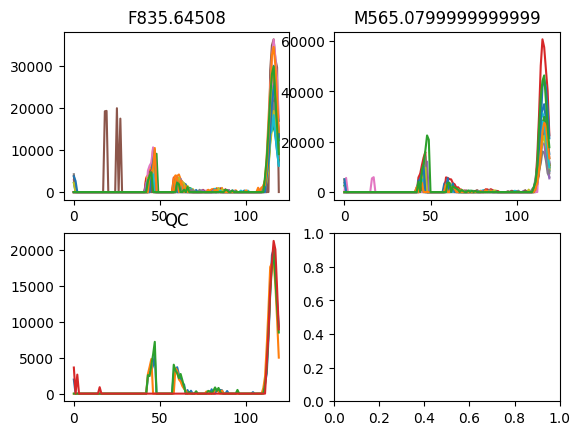

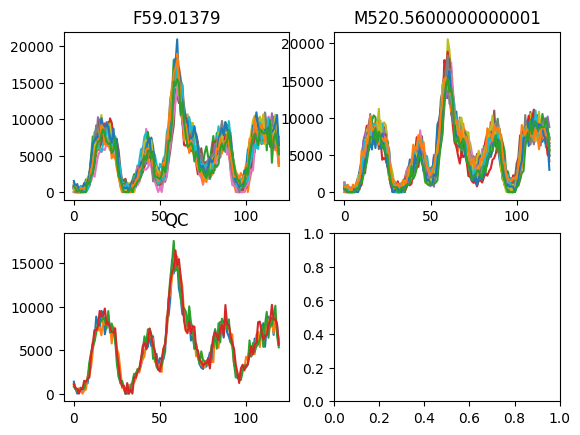

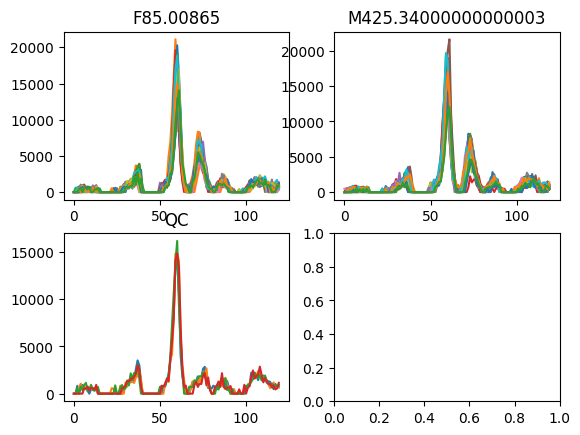

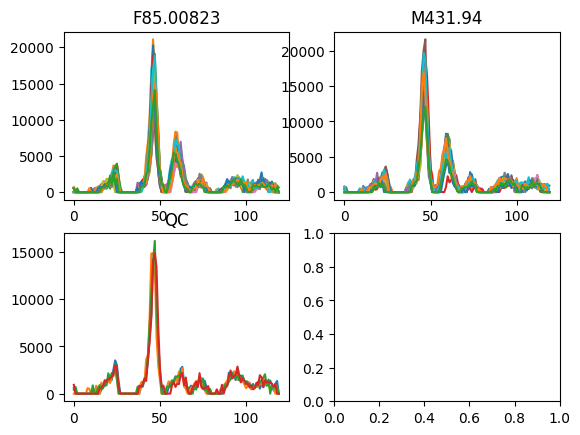

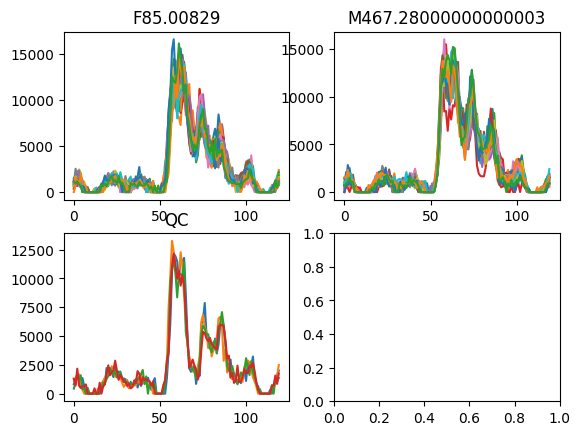

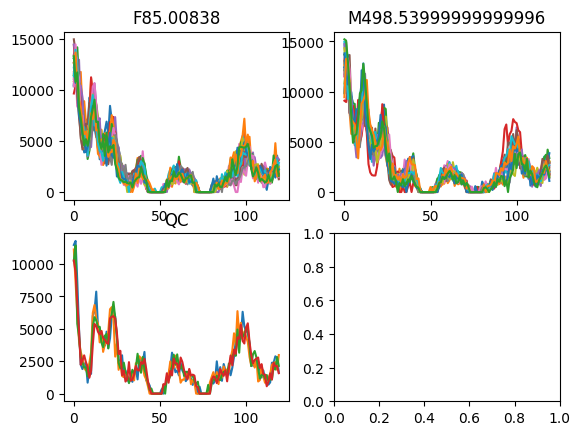

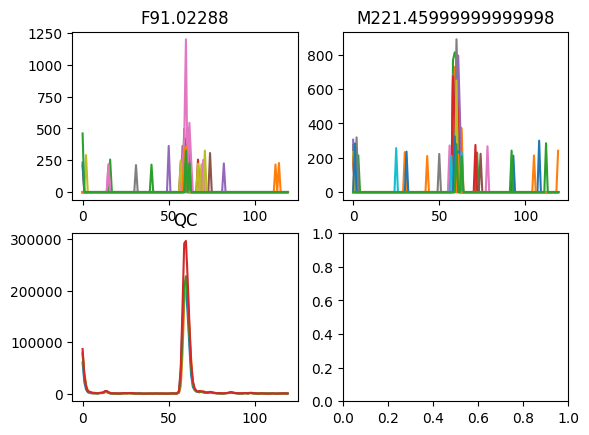

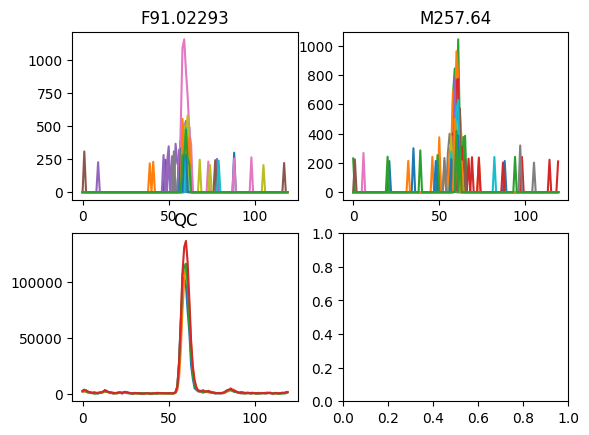

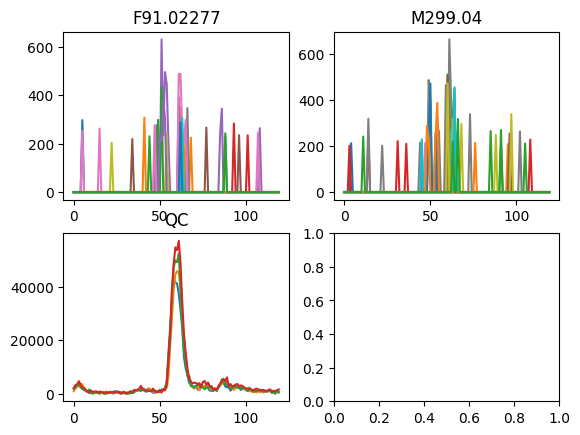

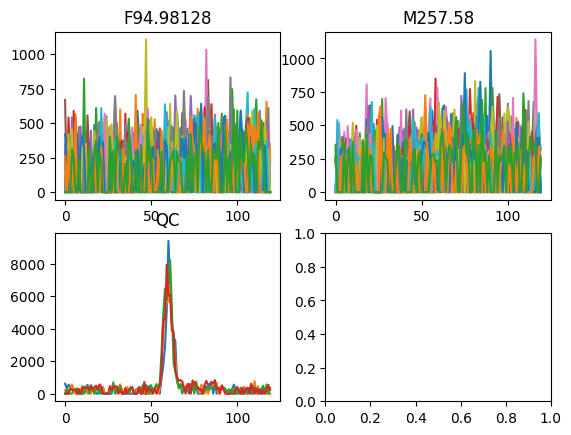

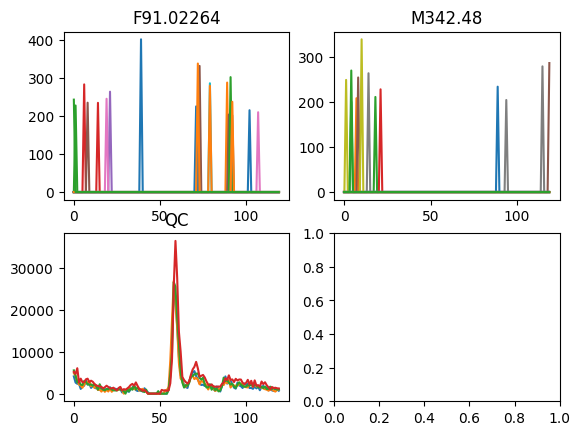

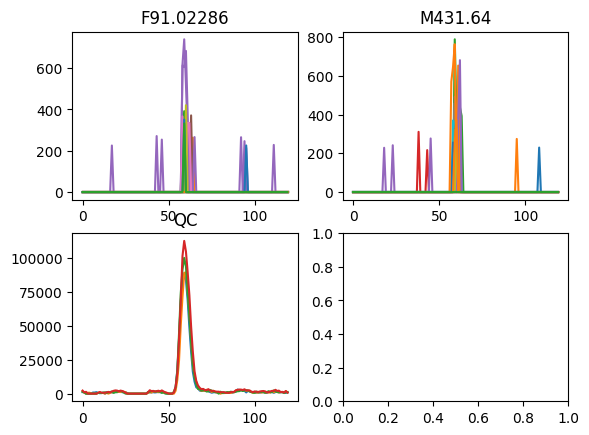

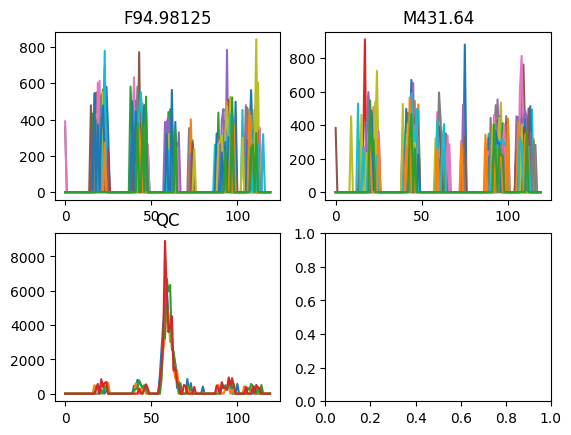

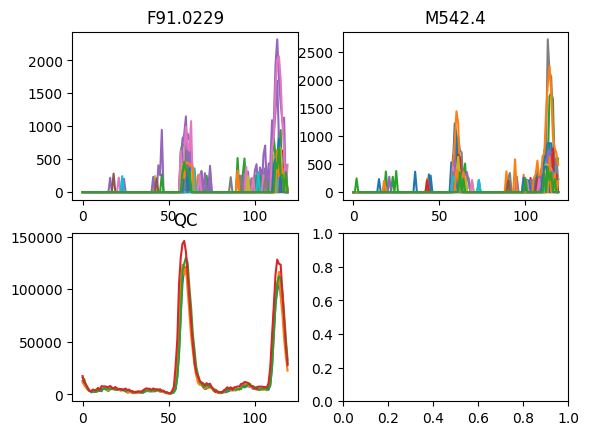

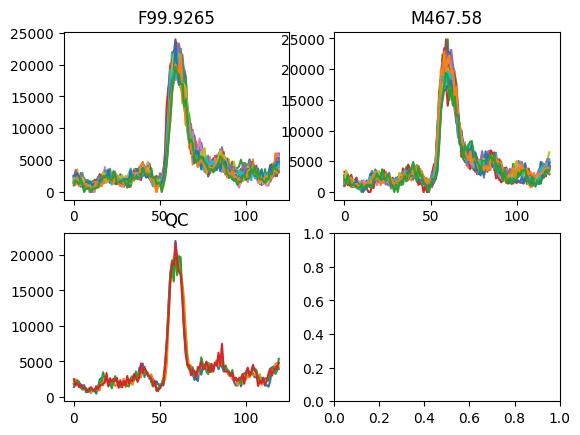

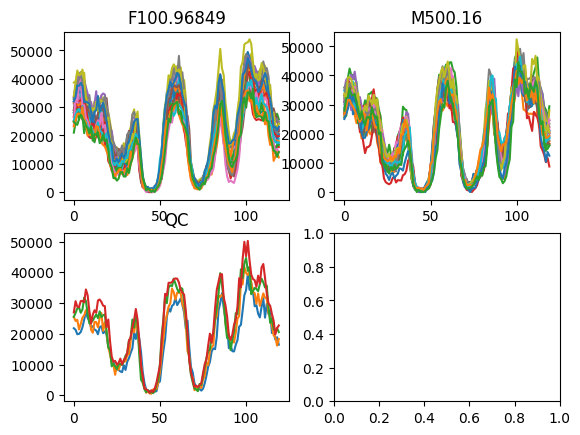

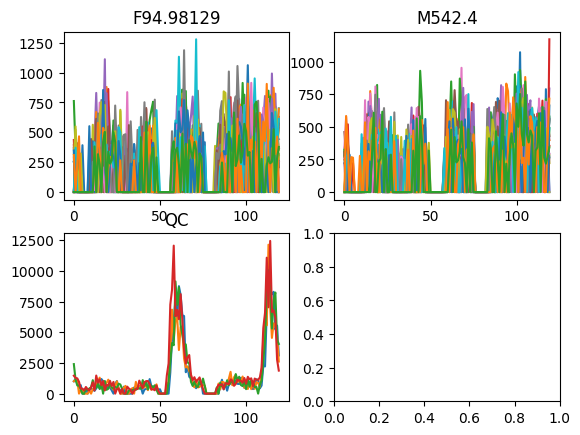

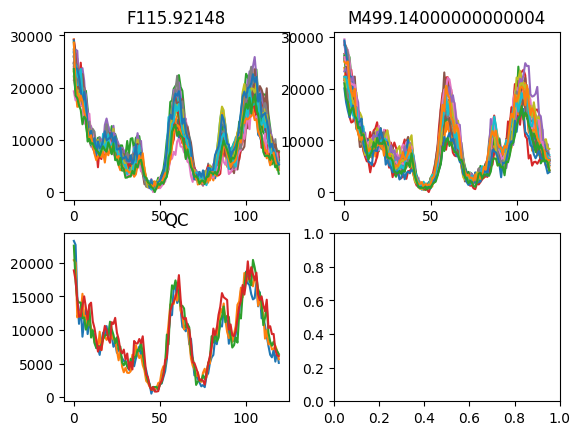

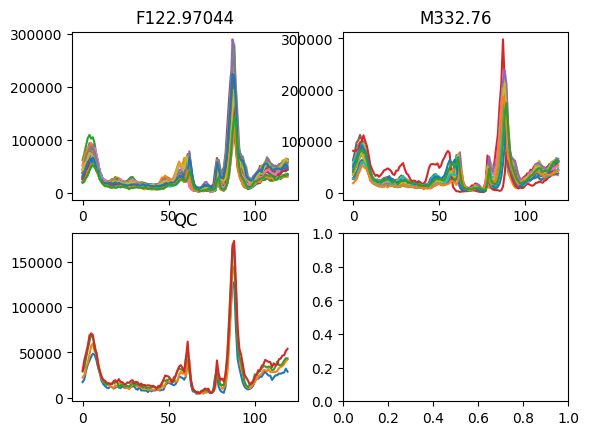

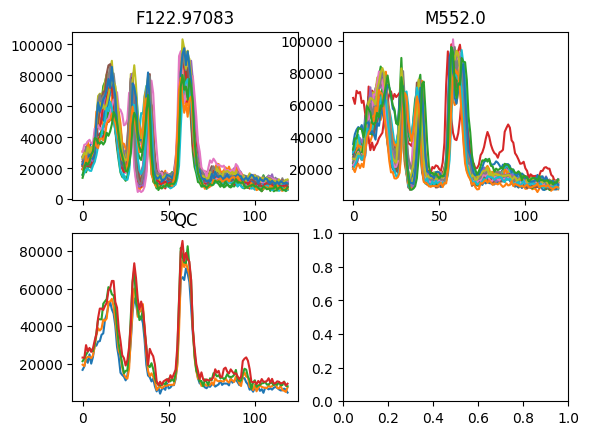

In [13]:
for e in list(me)[:20]:
    data.plot(e)